# 1 Import Packages

In [1]:
import xarray as xr
import numpy as np
import os
import datetime
import src.config as config
import src.utils as utils

import sklearn.linear_model
from tqdm import tqdm
import cartopy.crs as ccrs
import joblib
import glob

import matplotlib.pyplot as plt

# 2 Metadata

In [2]:
lev_index = 23
kfold_index = 0
exp_name = "cv"
datetime_string = datetime.datetime.now().strftime("%d_%m_%Y_%H_%M_%S")
problem_name = "streamfunction"

In [3]:
ml_transform_path = os.path.join(config.data_pro_path,"ml_transform", exp_name, problem_name)

In [5]:
train_x_filename = "train_data_stack_samplestandardized_lev_{}_{}.nc".format(lev_index, kfold_index)
valid_x_filename = "valid_data_stack_samplestandardized_lev_{}_{}.nc".format(lev_index, kfold_index)

train_y_filename = "train_data_amoc_depth_mask_lat_mask_samplestandardized_{}_{}.nc".format(lev_index, kfold_index)
valid_y_filename = "valid_data_amoc_depth_mask_lat_mask_samplestandardized_{}_{}.nc".format(lev_index, kfold_index)

In [6]:
model_name = "linear_level_{}_kfold_{}".format(lev_index, kfold_index)
model_path = os.path.join(config.model_path,exp_name, datetime_string,model_name)

model_plot_path = os.path.join(model_path, "plots")
os.makedirs(model_plot_path, exist_ok=True)

# 3 Load Data

In [7]:
train_x_xr = xr.open_dataset(os.path.join(ml_transform_path, train_x_filename))
valid_x_xr = xr.open_dataset(os.path.join(ml_transform_path, valid_x_filename))

In [8]:
train_y_xr = xr.open_dataset(os.path.join(ml_transform_path, train_y_filename))
valid_y_xr = xr.open_dataset(os.path.join(ml_transform_path, valid_y_filename))

train_data_amoc_depth_1020_lat_26_samplestd  = xr.load_dataset(os.path.join(ml_transform_path,"train_data_amoc_depth_1020_lat_26_samplestd.nc" ))
train_data_amoc_depth_1020_lat_26_samplemean = xr.load_dataset(os.path.join(ml_transform_path,"train_data_amoc_depth_1020_lat_26_samplemean,nc"))

# 4 Processing

In [9]:
train_x_xr_stack = train_x_xr.stack(sample=("realization","time")).stack(feature=("lon","lat"))
valid_x_xr_stack = valid_x_xr.stack(sample=("realization","time")).stack(feature=("lon","lat"))

feature_coords = train_x_xr_stack.feature
sample_coords = train_x_xr_stack.sample

train_x_xr_stack_dropna = train_x_xr_stack.dropna(dim="feature")
valid_x_xr_stack_dropna = valid_x_xr_stack.dropna(dim="feature")

feature_dropna_coords = train_x_xr_stack_dropna.feature

In [22]:
train_y_xr_stack = train_y_xr.isel(depth_2 = range(20,30), lat=range(20,30)).stack(sample=("realization","time"), feature=("depth_2","lat"))
valid_y_xr_stack = valid_y_xr.isel(depth_2 = range(20,30), lat=range(20,30)).stack(sample=("realization","time"), feature=("depth_2","lat"))

# 5 Model

In [23]:
valid_sample_coords = valid_y_xr_stack.sample
train_sample_coords = train_y_xr_stack.sample

feature_drop_coords = train_x_xr_stack_dropna.feature
feature_full_coords = train_x_xr_stack.feature 

train_x_ml_xr = train_x_xr_stack_dropna["rho"]
valid_x_ml_xr = valid_x_xr_stack_dropna["rho"]

train_y_ml_xr = train_y_xr_stack["atlantic_moc"]
valid_y_ml_xr = valid_y_xr_stack["atlantic_moc"]

train_y_true_ml_xr = train_y_xr_stack["atlantic_moc"]
valid_y_true_ml_xr = valid_y_xr_stack["atlantic_moc"]


In [24]:
def mse_xr(pred, true, sample_dim = "sample"):
    return np.square(pred - true).mean(dim=sample_dim)

## 5.1 Train

In [25]:
from sklearn.multioutput import MultiOutputRegressor

In [26]:
model = MultiOutputRegressor(sklearn.linear_model.Ridge(alpha=0), n_jobs=100).fit(train_x_ml_xr, train_y_ml_xr.unstack(dim="feature").stack(feature=("depth_2","lat")))

In [107]:
model.estimators_[0].coef_

array([ 0.0147784, -0.7840935, -1.115555 , ...,  1.8451006,  1.6331743,
       -2.681375 ], dtype=float32)

In [108]:
train_y_pred = model.predict(train_x_ml_xr)
valid_y_pred = model.predict(valid_x_ml_xr)

In [110]:
train_y_pred_xr = xr.DataArray(train_y_pred, name = "train_y_pred",  dims = ["sample","feature"], coords = {"sample": train_y_ml_xr.sample, "feature": train_y_ml_xr.feature})
valid_y_pred_xr = xr.DataArray(valid_y_pred, name = "valid_y_pred",  dims = ["sample","feature"], coords = {"sample": valid_y_ml_xr.sample, "feature": valid_y_ml_xr.feature})


In [113]:
depth = train_y_ml_xr.unstack().depth_2
lat = train_y_ml_xr.unstack().lat

In [127]:
valid_y_ml_xr.unstack().isel(realization=22, time=19)

<xarray.DataArray 'atlantic_moc' (depth_2: 10, lat: 10)>
array([[ 1.10837063,  1.1204044 ,  1.11025992,  1.03246048,  0.95640648,
         0.96108314,  1.04859663,  0.99159761,  0.78262024,  0.78621957],
       [ 1.22882579,  1.2384872 ,  1.22942074,  1.12358446,  1.0646548 ,
         1.12925868,  1.18035559,  1.13109699,  1.11833131,  1.06996086],
       [ 1.32033915,  1.30385109,  1.29860758,  1.20277469,  1.17975099,
         1.25617094,  1.29339356,  1.28830906,  1.41875218,  1.3388766 ],
       [ 1.324064  ,  1.31808142,  1.30032409,  1.25173458,  1.25096051,
         1.30274165,  1.35210028,  1.42595277,  1.47739   ,  1.33581945],
       [ 1.28230581,  1.28432517,  1.26266305,  1.24609921,  1.24731309,
         1.27250468,  1.33183033,  1.38553466,  1.38786266,  1.33597597],
       [ 1.17599114,  1.16510097,  1.16397307,  1.16725564,  1.18212639,
         1.20505557,  1.22918981,  1.28642417,  1.28110268,  1.25108368],
       [ 0.94849658,  0.94802315,  0.96776153,  0.98167496,  1.00726254,
         1.04051478,  1.06016167,  1.09826445,  1.11024945,  1.08015274],
       [ 0.65957571,  0.64449746,  0.67939938,  0.70601111,  0.73959609,
         0.78808971,  0.79525214,  0.81999745,  0.83814801,  0.83724745],
       [ 0.34443827,  0.33470714,  0.38485844,  0.37460786,  0.43419736,
         0.51194955,  0.49247916,  0.51077784,  0.53850342,  0.53419133],
       [-0.01381659,  0.00662035,  0.08485437,  0.0814427 ,  0.12782051,
         0.1896366 ,  0.17596347,  0.17557175,  0.20776291,  0.21415223]])
Coordinates:
  * depth_2      (depth_2) float64 690.0 790.0 900.0 ... 1.79e+03 1.98e+03
  * lat          (lat) float64 20.5 21.5 22.5 23.5 24.5 25.5 26.5 27.5 28.5 29.5
    realization  <U7 'lkm0023'
    time         datetime64[ns] 1869-07-16T11:15:00
    lon          float64 0.0

In [128]:
valid_y_ml_xr.unstack().isel(realization=22, time=1)

<xarray.DataArray 'atlantic_moc' (depth_2: 10, lat: 10)>
array([[0.95191224, 0.9946024 , 1.04908577, 1.05127763, 0.99982303,
        0.97698038, 1.00784013, 0.95647206, 0.76434692, 0.7999    ],
       [1.11145285, 1.13439306, 1.17072504, 1.15261223, 1.10735461,
        1.11840598, 1.12720211, 1.08639243, 1.11092514, 1.10509716],
       [1.23005675, 1.23491418, 1.26697321, 1.23906754, 1.22582127,
        1.24630423, 1.24101498, 1.23477006, 1.42534569, 1.39017523],
       [1.27204035, 1.28720238, 1.30182263, 1.30551111, 1.31207486,
        1.31628802, 1.32272308, 1.38389972, 1.48070371, 1.38773838],
       [1.27154212, 1.28168633, 1.30143932, 1.32228273, 1.31906216,
        1.31360371, 1.32484826, 1.36356666, 1.40124534, 1.39647636],
       [1.18064053, 1.17403213, 1.22973516, 1.25683892, 1.2556865 ,
        1.25016384, 1.24330771, 1.28189742, 1.31181473, 1.32331528],
       [0.95680991, 0.98359401, 1.04435592, 1.08438878, 1.09565454,
        1.08976952, 1.08010121, 1.109253  , 1.14963472, 1.16723111],
       [0.66675053, 0.69437553, 0.76965325, 0.82151225, 0.83042976,
        0.84149657, 0.81629506, 0.83808311, 0.88564697, 0.93308516],
       [0.38023083, 0.38655566, 0.4843849 , 0.48908196, 0.51808631,
        0.55846197, 0.50897424, 0.52774814, 0.57931902, 0.62790565],
       [0.03425899, 0.0535617 , 0.18387682, 0.18834377, 0.19284628,
        0.22556887, 0.1757787 , 0.17540531, 0.23370584, 0.28887399]])
Coordinates:
  * depth_2      (depth_2) float64 690.0 790.0 900.0 ... 1.79e+03 1.98e+03
  * lat          (lat) float64 20.5 21.5 22.5 23.5 24.5 25.5 26.5 27.5 28.5 29.5
    realization  <U7 'lkm0023'
    time         datetime64[ns] 1851-07-16T11:15:00
    lon          float64 0.0

In [ ]:
train_y_ml_xr.mean(dim="sample")

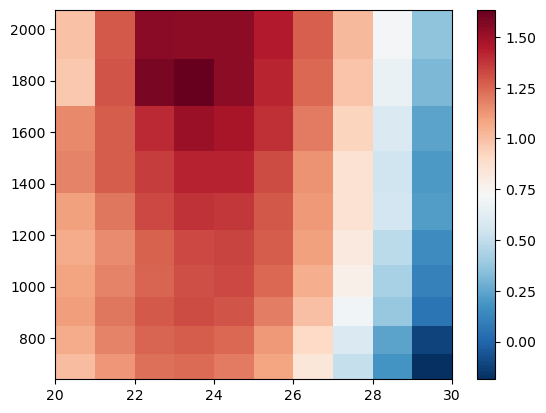

In [143]:
plot = plt.pcolormesh(lat,depth, train_y_ml_xr.unstack().isel(realization=22, time=93).transpose("lat","depth_2"), cmap="RdBu_r")

plt.colorbar(plot)

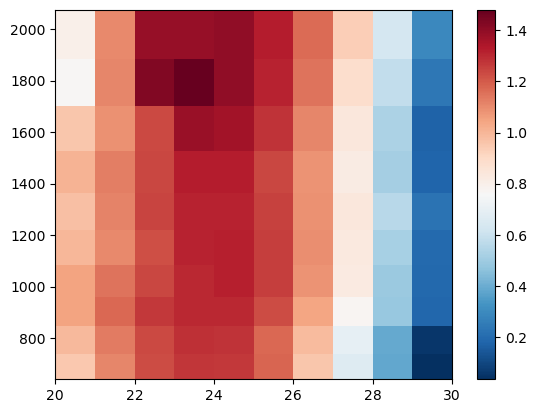

In [130]:
plot = plt.pcolormesh(lat,depth, valid_y_ml_xr.unstack().isel(realization=22, time=1).transpose("lat","depth_2"), cmap="RdBu_r")

plt.colorbar(plot)

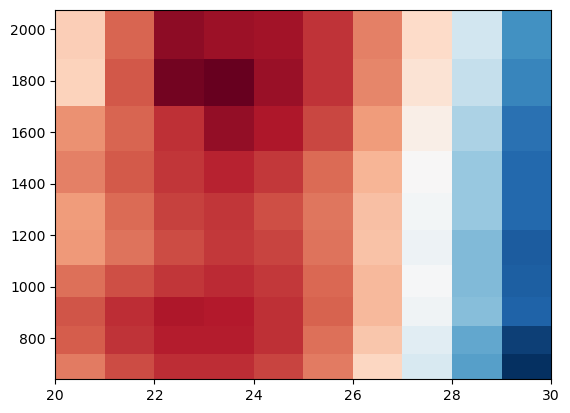

In [119]:
plt.pcolormesh(lat,depth, valid_y_pred_xr.unstack().isel(realization=19, time=12).transpose("lat","depth_2"), cmap="RdBu_r")

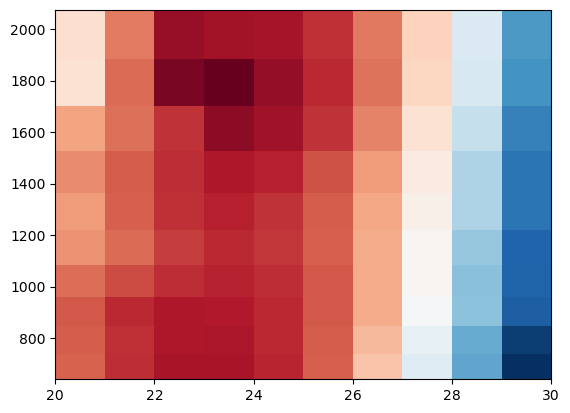

In [79]:
plt.pcolormesh(lat,depth, train_y_pred_xr.isel(sample=0).unstack(dim="feature").transpose("lat","depth_2"), cmap="RdBu_r")

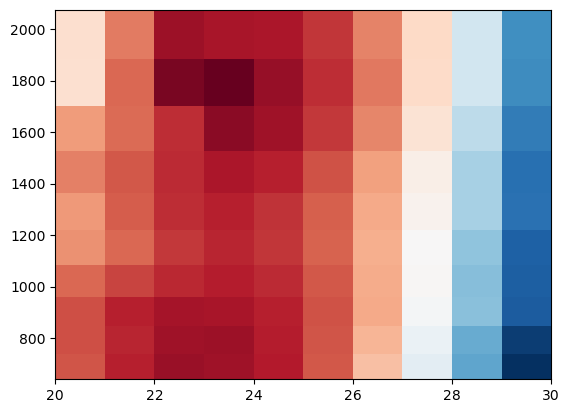

In [68]:
plt.pcolormesh(lat,depth, train_y_ml_xr.isel(sample=0).unstack(dim="feature").transpose("lat","depth_2"), cmap="RdBu_r")

In [51]:
train_y_pred

(13600, 100)

In [ ]:
alpha_list = np.logspace(-2,4, 100)

In [ ]:
train_mse_list = []
valid_mse_list = []


for i,alpha in tqdm(enumerate(alpha_list)): 
    sklearn.MultiOutputRegressor()
    model = sklearn.linear_model.Ridge(alpha = alpha)
    model.fit(train_x_ml_xr, train_y_ml_xr)
    
    model_coef_ml_xr = xr.DataArray(model.coef_, dims = ["feature"], coords ={"feature":feature_drop_coords} )
    model_coef_tmp,_ = xr.align(model_coef_ml_xr, feature_coords, join="outer")

    train_y_pred_ml_np = model.predict(train_x_ml_xr)
    valid_y_pred_ml_np = model.predict(valid_x_ml_xr)

    train_y_pred_ml_xr = xr.DataArray(train_y_pred_ml_np, dims= ["sample"], coords = {"sample": train_sample_coords, "alpha":alpha})
    valid_y_pred_ml_xr = xr.DataArray(valid_y_pred_ml_np, dims= ["sample"], coords = {"sample": valid_sample_coords, "alpha":alpha})


    train_mse_tmp = mse_xr(train_y_pred_ml_xr, train_y_true_ml_xr)
    valid_mse_tmp = mse_xr(valid_y_pred_ml_xr, valid_y_true_ml_xr)
    
    model_name = "model_{}.sav".format(i)
    model_file = os.path.join(model_path, model_name)
    joblib.dump(model, model_file)
    

    if i == 0: 
        model_coef = model_coef_tmp.assign_coords({"alpha": alpha})
        train_mse = train_mse_tmp.assign_coords({"alpha":alpha})
        valid_mse = valid_mse_tmp.assign_coords({"alpha":alpha})
        train_pred = train_y_pred_ml_xr.assign_coords({"alpha":alpha})
        valid_pred = valid_y_pred_ml_xr.assign_coords({"alpha":alpha})

    else:
        model_coef = xr.concat([model_coef, model_coef_tmp.assign_coords({"alpha":alpha})], dim="alpha")
        train_mse = xr.concat([train_mse, train_mse_tmp.assign_coords({"alpha":alpha})], dim="alpha")
        valid_mse = xr.concat([valid_mse, valid_mse_tmp.assign_coords({"alpha":alpha})], dim="alpha")
        train_pred = xr.concat([train_pred, train_y_pred_ml_xr.assign_coords({"alpha":alpha})], dim="alpha")
        valid_pred = xr.concat([valid_pred, valid_y_pred_ml_xr.assign_coords({"alpha":alpha})], dim="alpha")
        

    data = xr.merge([
        model_coef.rename("coefficients"),
        train_mse.rename("train_mse"), 
        valid_mse.rename("valid_mse"),
        valid_pred.rename("valid_pred"),
        train_pred.rename("train_pred"),
        ])


0it [00:00, ?it/s]/work/uo1075/u301101/programming/miniconda3/envs/CNN/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.09629e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
1it [00:05,  5.08s/it]/work/uo1075/u301101/programming/miniconda3/envs/CNN/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.38278e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
2it [00:08,  4.12s/it]/work/uo1075/u301101/programming/miniconda3/envs/CNN/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.71316e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
3it [00:13,  4.60s/it]/work/uo1075/u301101/programming/miniconda3/envs/CNN/lib/python3.8/site-packages/sklearn/linear_model/_ridge.